In [2]:
# encoding: UTF-8
# Copyright Diogenes Ademir Domingos 2017
# Authored by Diogenes Ademir Domingos (k.fus@hotamil.com)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [66]:
# Configunrando o notebook.

import itertools
import random
import numpy as np
import matplotlib.pyplot as plt

# Configunrando o framework Keras.

# Importando a base de dados MNIST (http://yann.lecun.com/exdb/mnist/)
from keras.datasets import mnist

# Importando o modelo do Keras (https://keras.io/getting-started/sequential-model-guide/)
from keras.models import Sequential

# Importando o tipo de camada
from keras.layers import Dense

# Importando modulo de Dropout da rede, para aplicar mutações.
from keras.layers import Dropout

# Importando modulo de achatamento dos vetores.
# Aprimora a entrada. Não afeta o tamanho do lote.
# (https://keras.io/layers/core/#flatten)
from keras.layers import Flatten

# Importanto modulo de convolução (https://keras.io/layers/convolutional/)
from keras.layers.convolutional import Conv2D

# Importando modulo de subamostragem (https://keras.io/layers/pooling/)
from keras.layers.convolutional import MaxPooling2D

# Importando Lib de utilidades (https://keras.io/utils/)
from keras.utils import np_utils

# Importante modulo de trabalho em backend (Th ou Tf) (https://keras.io/backend/)
from keras import backend as K

# modulo para trabalhar reprocessar as imagens
from keras.preprocessing import image

# modulo de utilizades para trabalhar reprocessar as imagens
from keras.utils.data_utils import get_file

# modulo de callback para parar o treinamento na melhor opção
from keras.callbacks import EarlyStopping

# Modulo Scikit-Learn para montar a matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score


#import keras_mnist_vis 
#K.set_image_dim_ordering('th')

# permitindo mais de um print por saída
from __future__ import print_function

# Configurando o plot para ser inline ao inves de outra janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load dos dados
# Criando uma matriz numpy de dados de treino.
# Criando uma matriz numpy de dados de teste.
# O conjunto de treinamento possui 60.000 exemplos
# O conjunto de testes de 10.000 exemplos

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('Dados de treino shape: ', X_train.shape)
print('Rotulos de treino shape: ', y_train.shape)
print('Dados de teste shape: ', X_test.shape)
print('Rotulos de teste: ', y_test.shape)

Dados de treino shape:  (60000, 28, 28)
Rotulos de treino shape:  (60000,)
Dados de teste shape:  (10000, 28, 28)
Rotulos de teste:  (10000,)


In [6]:
# backup para predição

X_test_orig = X_test
print('Dados de teste backup: ', X_test_orig.shape)

Dados de teste backup:  (10000, 28, 28)


#Amostragem
#Como o conjunto é muito grande para processar na maquina inloco, reduzi criei um subconjunto para experimento.
#Depois de encontrar o melhot modelo, fiz o treinamento com a base integral
amostra_treino = 5000
mascara = list(range(amostra_treino))
X_train = X_train[mascara]
y_train = y_train[mascara]

amostra__teste = 500
mask = list(range(amostra__teste))
X_test = X_test[mascara]
y_test = y_test[mascara]

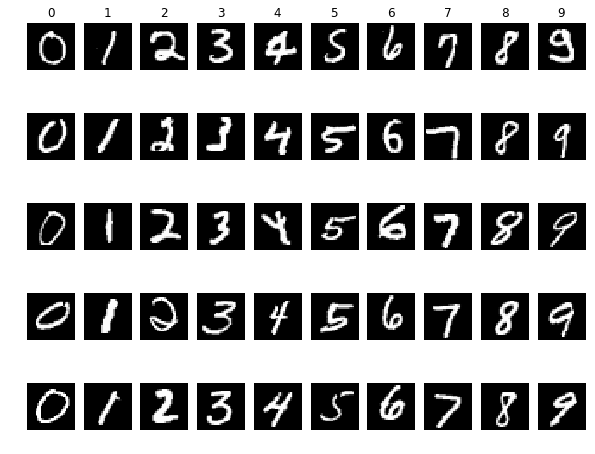

In [7]:
# Visualizando amostra dos dados
# Vetor de classes para indice
classes = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
quantidade_classes = len(classes)
amostras_por_classe = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, amostras_por_classe, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * quantidade_classes + y + 1
        plt.subplot(amostras_por_classe, quantidade_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# Configuração do shape da imagem
# Este shape varia de acordo com o framework de backend
# tenshoflow = (quantidade de canais, largura, altura)
# theano = (largura, altura, quantidade de canais)

img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    shape = (1, img_rows, img_cols)
else:  # channel_last
    shape = (img_rows, img_cols, 1)

print(shape)

(28, 28, 1)


In [9]:
# Alterando os canais de cor para ter apenas um canal
X_train = X_train.reshape((X_train.shape[0],) + shape).astype('float32')
X_test = X_test.reshape((X_test.shape[0],) + shape).astype('float32')

In [10]:
# Binarizando pixels
X_train = X_train / 255
X_test = X_test / 255

In [11]:
# Visualizando dimensão dos dados.
# (Quantidade, largura, altura)
print('Dados de treino shape: ', X_train.shape)
print('Rotulos de treino shape: ', y_train.shape)
print('Dados de teste shape: ', X_test.shape)
print('Rotulos de teste: ', y_test.shape)

Dados de treino shape:  (60000, 28, 28, 1)
Rotulos de treino shape:  (60000,)
Dados de teste shape:  (10000, 28, 28, 1)
Rotulos de teste:  (10000,)


Formato do dataset: (60000, 28, 28, 1)
Labels: [5 0 4 ..., 5 6 8]
Labels shape: (60000,)
Formato da imagem: (28, 28, 1)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.047059,0.388235,0.356863,0.556863,0.607843,0.964706,0.713726,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.541176,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.129412,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.862745,0.996078,0.996078,0.996078,0.921569,0.741176,0.741176,...,0.294118,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.137255,0.290196,0.137255,0.137255,0.098039,0.000000,0.000000,...,0.600000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.207843,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


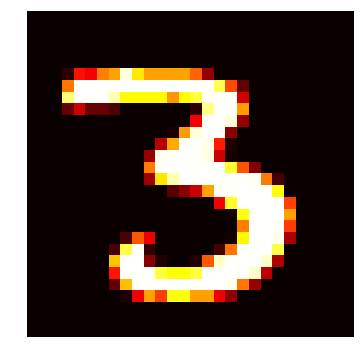

In [12]:
# Visualizar a matriz de pixels da imagem.
from IPython.display import display
import pandas as pd

print("Formato do dataset: {}".format(X_train.shape))
print("Labels: {}".format(y_train))
print("Labels shape: {}".format(y_train.shape))

# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, len(X_train[0]))
img_aleatoria = X_train[idx_img_aleatoria]
print("Formato da imagem: {}".format(img_aleatoria.shape))

# Visualizar a imagem aleatoria
plt.figure(figsize=(6,6))
plt.imshow(img_aleatoria.reshape(28,28), cmap='hot')
plt.axis('off')

# Imprime os pixels da imagem como tabela
display(pd.DataFrame(img_aleatoria.reshape(28,28)))

In [13]:
# Definindo a qunatidade de neurõnios por camada da RNA

# quantidade de pixels na camada de entrada de dados
# um neuronio para cada pixel
if K.image_data_format() == 'channels_first':
    num_pixels = X_train.shape[2] * X_train.shape[3]
else:
    num_pixels = X_train.shape[1] * X_train.shape[2]
    
print("Quantidade de neurônios (camada entrada): ",num_pixels)

Quantidade de neurônios (camada entrada):  784


In [14]:
# criando a classificação
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [15]:
# verificando a quantidade de classes encontradas
num_classes = y_test.shape[1]
print('Classes encontradas shape: ',y_test.shape)

Classes encontradas shape:  (10000, 10)


In [44]:
# Criando arquitetura da rede DNN
def deep_cnn_model(num_pixels, num_classes, shape, activation='relu'):
    
    # inicialização de hyperparamentros
    # Quantidade de núcleos (Campos receptivos locais)
	nucleos = 32
    # Dimensão dos núcleos
	nucleos_dim_1 = 3
    # Dimensão dos núcleos para maxpooling
	nucleos_dim_2 = 2
    # Quantida de de neuônios para camada totalmente conectada
	neuronios_camada_densa = 128
    
	model = Sequential() # tipo keras senquencial (https://keras.io/getting-started/sequential-model-guide/)
  
    # [Primeira camada]
    # Adicionando uma camada de convolução (Convolution2D - com esparsividade) para entrada de dados. 
    # Camada ConvNet terá 32 núcleos (campos receptivos de 3 x 3 pixels).
    # Arranjo espacial cmo apenas 1 canal de cor e imagem com dimesão de 28 x 28
    # Padding = same, o tamanho da saída será igual ao tamanho da entrada: input=(28,28) -> output=(28,28)
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))  
    # Por default a rede CONV2D já utiliza bias=True e os inicializa com 0
    # Por default o tamanho do passo é 1 pixel, stride=(1,1)
	model.add(Conv2D(nucleos, (nucleos_dim_1, nucleos_dim_1), padding='same', input_shape=shape, activation= activation))
    
    #[Segunda Camada]
    # Adicionando uma camada de convolução (Convolution2D - com esparsividade).
    # Camada ConvNet terá 64 núcleos (campos receptivos de 3 x 3 pixels).
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) 
	model.add(Conv2D(nucleos * 2, (nucleos_dim_1, nucleos_dim_1), activation= activation))
    
    # [Terceira Camada]
    # Adicionando uma camada de subamostragem (MaxPooling2D).
    # Imagens redimensionadas para 2 × 2 pixels.
	model.add(MaxPooling2D(pool_size=(nucleos_dim_2, nucleos_dim_2)))
       
    # [Quarta Camada]
    # O dropout atribui, aleatoriamente à entrada de uma fração unidades, valor 0
    # em cada época de treinamento. Ajuda a evitar a overfitting
    # parâmentro (0 > x < 1) é a taxa % de queda
	model.add(Dropout(0.25))
    
    # [Quinta camada]
    # Achata o vetor
    # Aprimora a entrada, tranforma uma imagem de input=(13,13) e com 64 núcleos, em um vetor de 10.816 posições (28*28*64)
    # Não afeta o tamanho do lote.
	model.add(Flatten())
    
    #[Sexta Camada]
    # Adicionando camada densa (totalmente conectada), destinada a classificação.
    # Possui 128 neurônios de entrada.
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
	model.add(Dense(neuronios_camada_densa, activation= activation))
    
    #[Sétima camada]
    # O dropout atribui, aleatoriamente à entrada de uma fração unidades, valor 0
    # em cada época de treinamento. Ajuda a evitar a overfitting
    # parâmentro (0 > x < 1) é a taxa % de queda
	model.add(Dropout(0.50))
        
    #[Oitava Camada]
    # Adicionando uma camada densa (totalmente conectada) para saída de dados, 
    # Função de ativação do neurônio será Softmax (https://en.wikipedia.org/wiki/Softmax_function)
    # Nome da camada de saída é predição (Opcional)
	model.add(Dense(num_classes, activation='softmax', name='preds'))
    
    # Função para otimização estocástica, requer apenas gradientes de primeira ordem com pouco requisito de memória.
    # Referência: (KINGMA, Diederik; BA, Jimmy. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980, 2014.)
    # lr: taxa de aprendizado
    # decay: tamanho do passo da caída do gradiente
	# adam = keras.optimizers.Adam(lr=0.01, decay=1e-6)
	#adadelta = keras.optimizers.Adadelta()
        
    # Copilando o modelo
    # Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
    # métrica de reconhecimento será precisão.
    # utilizão adam padrão, sem alterar lr.
	#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    # retorna o modelo compilado
	return model

In [45]:
# instanciando o modelo RNA
model = deep_cnn_model(num_pixels, num_classes, shape)

In [46]:
# Descrevendo a representação do modelo DNN
# Arranjo dimensional: 
# 1 camada de entrada;
# 2 camadas ocultas;
# 1 camada de saída (preds);
# quantidade de parâmentros da rede (pesos).
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 10816)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1384576   
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
__________

In [47]:
# Verificando o arranjo espacial do modelo
for i, layer in enumerate(model.layers):
    print ("Camada", i, "\t", layer.name.strip(),"\t\t", layer.input_shape, "\t", layer.output_shape)

Camada 0 	 conv2d_19 		 (None, 28, 28, 1) 	 (None, 28, 28, 32)
Camada 1 	 conv2d_20 		 (None, 28, 28, 32) 	 (None, 26, 26, 64)
Camada 2 	 max_pooling2d_10 		 (None, 26, 26, 64) 	 (None, 13, 13, 64)
Camada 3 	 dropout_19 		 (None, 13, 13, 64) 	 (None, 13, 13, 64)
Camada 4 	 flatten_10 		 (None, 13, 13, 64) 	 (None, 10816)
Camada 5 	 dense_10 		 (None, 10816) 	 (None, 128)
Camada 6 	 dropout_20 		 (None, 128) 	 (None, 128)
Camada 7 	 preds 		 (None, 128) 	 (None, 10)


In [48]:
# Verificando o arranjo espacial do modelo com o pesos
# W.shape = matriz de pesos (quantidade de entradas, quantidade de saídas)
# b.shape = matriz de viés(bias)
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        W, b = layer.get_weights()
        print("Camada", i, "\t", layer.name, "\t\t", W.shape, "\t", b.shape)

Camada 0 	 conv2d_19 		 (3, 3, 1, 32) 	 (32,)
Camada 1 	 conv2d_20 		 (3, 3, 32, 64) 	 (64,)
Camada 5 	 dense_10 		 (10816, 128) 	 (128,)
Camada 7 	 preds 		 (128, 10) 	 (10,)


In [49]:
# Retorna a configuração do modelo DNN
model.get_config()

[{'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 28, 28, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'dtype': 'float32',
   'filters': 32,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': (3, 3),
   'name': 'conv2d_19',
   'padding': 'same',
   'strides': (1, 1),
   'trainable': True,
   'use_bias': True}},
 {'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),

In [50]:
# Verificando os pesos da DNN
model.get_weights()

[array([[[[-0.0570711 , -0.10072792,  0.03376386, -0.13739803, -0.11107234,
            0.13413186, -0.09066433,  0.04299541, -0.0296479 , -0.05024954,
            0.05377494, -0.05191636,  0.10600445,  0.02667269,  0.13077964,
            0.13319202, -0.01079033, -0.11691811,  0.10686991, -0.06283669,
           -0.07872094, -0.0833121 , -0.00121199,  0.01781404, -0.01490477,
           -0.04787089, -0.09535611,  0.07982546, -0.10240661,  0.09226882,
            0.07412253,  0.00928168]],
 
         [[ 0.07832585,  0.07307436,  0.09347251, -0.01007545,  0.09397496,
           -0.09762533,  0.13710342,  0.13569532,  0.04156099,  0.05606434,
            0.10979061,  0.05049753,  0.04129311, -0.10389097, -0.06911937,
           -0.01454441,  0.11847503,  0.06283951, -0.05548141, -0.11500822,
           -0.03171266,  0.08330044,  0.0962911 , -0.02828003,  0.00606404,
           -0.12110381, -0.01706231, -0.0646707 ,  0.10991694,  0.13791038,
            0.03265309,  0.05239855]],
 
      

In [55]:
# Treinando o modelo DNN para 01 época
# Função FIT: realiza o treinamento até uma quantidade de épocas determinada.
# parametro validation_data: Dados para avaliar a perda do gradiente ao final de cada época
# parametro batch_size: numero de amostras para atualizar a perda do gradientes
# Paramentro verbose : 0 = silent, 1 = verbose, 2 = one log line per epoch.
# %time = medindo tempo do treino

# monitor para ouvir e parar o treinamento caso o aprendizado comece a cair
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

# treinando a DNN para 1 épocas
%time history = model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[monitor],epochs=1, batch_size=128, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 247s - loss: 0.1143 - acc: 0.9666 - val_loss: 0.0531 - val_acc: 0.9835
Wall time: 4min 7s


In [56]:
# Avaliando o modelo DNN
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, y_test, verbose=0)
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
Erro de: 1.65%
Precisão de: 98.35%


In [57]:
# Treinando o modelo RNA para 05 épocas
# %time = medindo tempo do treino

# monitor para ouvir e parar o treinamento caso o aprendizado comece a cair
# monitor: qual métrica vai monitorar.
# min_delta : a alteração mínima na métrica monitorada para se qualificar como uma melhoria
# paciência : número de épocas sem melhoria, após o que o treinamento será interrompido.
# Referência: https://keras.io/callbacks/#earlystopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

# treinando a DNN para 5 épocas
%time history = model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[monitor],epochs=5, batch_size=128, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 262s - loss: 0.0867 - acc: 0.9743 - val_loss: 0.0440 - val_acc: 0.9850
Epoch 2/5
60000/60000 [==============================] - 315s - loss: 0.0713 - acc: 0.9789 - val_loss: 0.0389 - val_acc: 0.9867
Epoch 3/5
60000/60000 [==============================] - 260s - loss: 0.0635 - acc: 0.9813 - val_loss: 0.0361 - val_acc: 0.9880
Epoch 4/5
60000/60000 [==============================] - 261s - loss: 0.0567 - acc: 0.9829 - val_loss: 0.0347 - val_acc: 0.9892
Epoch 5/5
60000/60000 [==============================] - 261s - loss: 0.0510 - acc: 0.9848 - val_loss: 0.0310 - val_acc: 0.9890
Wall time: 22min 41s


In [58]:
# Avaliando o modelo DNN
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, y_test, verbose=1)
print()
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
 9984/10000 [============================>.] - ETA: 0s
Erro de: 1.10%
Precisão de: 98.90%


In [59]:
# Treinando o modelo DNN para 12 épocas
# %time = medindo tempo do treino

# monitor para ouvir e parar o treinamento caso o aprendizado comece a cair
# monitor: qual métrica vai monitorar.
# min_delta : a alteração mínima na métrica monitorada para se qualificar como uma melhoria
# paciência : número de épocas sem melhoria, após o que o treinamento será interrompido.
# Referência: https://keras.io/callbacks/#earlystopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

# treinando a DNN para 20 épocas
%time history = model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[monitor],epochs=20, batch_size=128, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 254s - loss: 0.0485 - acc: 0.9855 - val_loss: 0.0286 - val_acc: 0.9899
Epoch 2/20
60000/60000 [==============================] - 255s - loss: 0.0448 - acc: 0.9866 - val_loss: 0.0311 - val_acc: 0.9890
Epoch 3/20
60000/60000 [==============================] - 256s - loss: 0.0408 - acc: 0.9879 - val_loss: 0.0278 - val_acc: 0.9895
Epoch 4/20
60000/60000 [==============================] - 255s - loss: 0.0398 - acc: 0.9883 - val_loss: 0.0277 - val_acc: 0.9899
Epoch 5/20
60000/60000 [==============================] - 255s - loss: 0.0377 - acc: 0.9885 - val_loss: 0.0297 - val_acc: 0.9900
Epoch 6/20
60000/60000 [==============================] - 256s - loss: 0.0360 - acc: 0.9894 - val_loss: 0.0276 - val_acc: 0.9899
Epoch 7/20
60000/60000 [==============================] - 255s - loss: 0.0337 - acc: 0.9896 - val_loss: 0.0283 - val_acc: 0.9907
Epoch 00006: early stopping
Wall time: 29min 51

In [60]:
# Avaliando o modelo RNA
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, y_test, verbose=1)
print()
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
 9984/10000 [============================>.] - ETA: 0s
Erro de: 0.93%
Precisão de: 99.07%


In [61]:
# Historico do treino
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


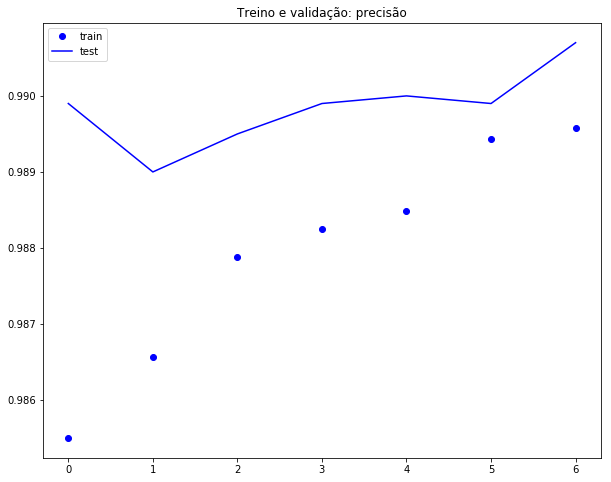

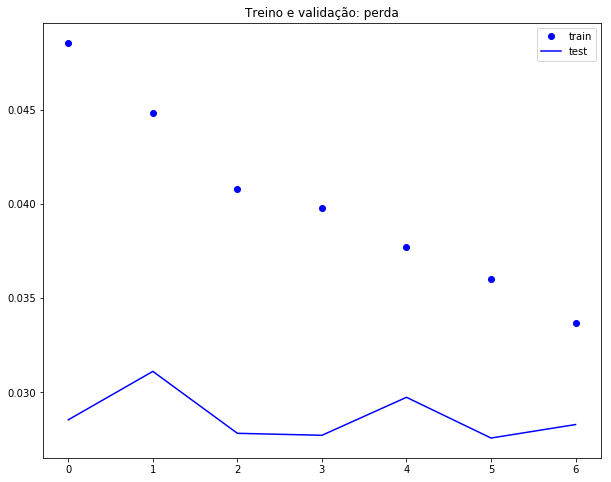

In [62]:
# Historio de precição
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Treino e validação: precisão')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.legend(['train', 'test'], loc='upper right')
plt.title('Treino e validação: perda')

plt.show()

In [63]:
# utilizando o modelo para predição.
predicted = model.predict(X_test,batch_size=32, verbose=1).argmax(-1)
print('\nQuantidade de imagens analisadas: ', predicted.shape)

10000/10000 [==============================] - 13s    

Quantidade de imagens analisadas:  (10000,)


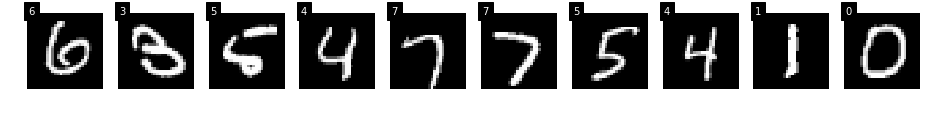

In [64]:
# Visualizando e comparando a predição com a base original.
amosta = 10
plt.figure(figsize=(16,8))
for i in range(amosta):
    plt.subplot(1, amosta, i+1)
    # Seleciona uma imagem aleatoria
    idx_img_aleatoria = random.randint(0, len(X_train[0]))
    img_aleatoria = X_test[idx_img_aleatoria]
    
    # Visualiza a imagem escolhida aleatoriamente
    plt.imshow(img_aleatoria.reshape(28,28), interpolation='nearest')
    
    # Visualiza o label
    plt.text(0, 0, predicted[idx_img_aleatoria], color='white', 
             bbox=dict(facecolor='black', alpha=1))
    plt.axis('off')

In [65]:
# Função para matriz de confusão da predição
# Referência: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Base de teste')
    plt.xlabel('Predições')

Verificando formato dos dados da predição: (10000,)
Verificando formato dos dados de testes: (10000, 10)


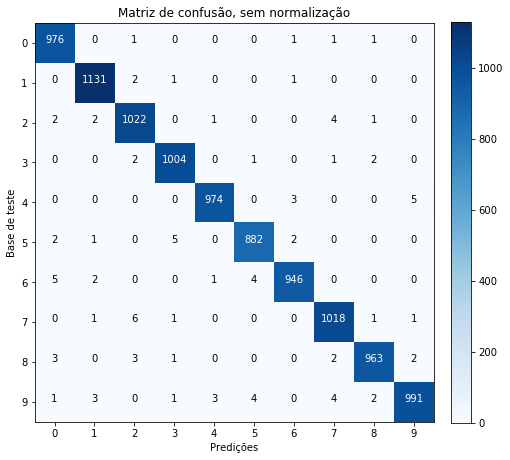

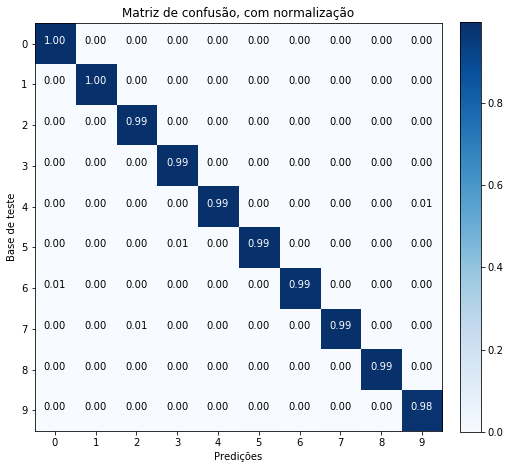

In [67]:
# Visualizando matriz de confusão da predição

# Precisa ter o mesmo formato
print('Verificando formato dos dados da predição: {}'.format(predicted.shape))
print('Verificando formato dos dados de testes: {}'.format(y_test.shape))

#print(confusion_matrix(np.argmax(y_test,axis=1), predicted))

cnf_matrix = confusion_matrix(np.argmax(y_test,axis=1), predicted)
np.set_printoptions(precision=2)

# Visualizando a matriz de confusão sem normalização.
# mosta a quantidade de imagens classificadas para cada label
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Matriz de confusão, sem normalização')

# Visualizando a matriz de confusão com normalização.
# mosta a precisão para cada label classificado
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Matriz de confusão, com normalização')

plt.show()

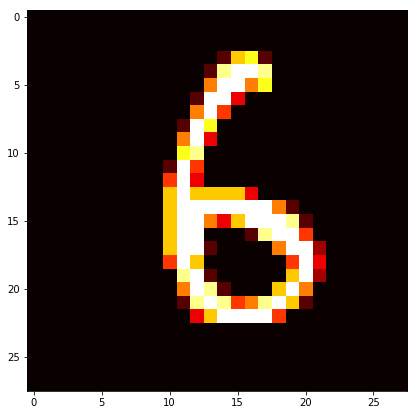

In [69]:
# Visualizando o mapa de calor

# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, X_test.shape[0])
img_aleatoria = X_test_orig[idx_img_aleatoria]

input_img_data = X_test[idx_img_aleatoria].reshape(28,28)
plt.figure(figsize=(7,7))
plt.imshow(input_img_data, cmap="hot")

In [232]:
input_img_data = np.expand_dims(input_img_data, axis=0)
print('Input image shape:', input_img_data.shape)

Input image shape: (1, 1, 28, 28, 1)


In [233]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 10816)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1384576   
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
__________

In [234]:
# Listando as camadas da rede
from collections import OrderedDict
layer_dict = OrderedDict()
for layer in model.layers[0:]:
    layer_dict[layer.name] = layer
    print(layer.name)

conv2d_19
conv2d_20
max_pooling2d_10
dropout_19
flatten_10
dense_10
dropout_20
preds


In [235]:
# Buscando as ativações da camada de convolucao

def get_activations(model, layer, input_img_data):
    activations_f = K.function([model.layers[0].input, K.learning_phase()], [layer.output,])
    activations = activations_f((input_img_data, False))
    return activations

In [265]:
# Verificando o shape

img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    shape = (1, img_rows, img_cols)
else:  # channel_last
    shape = (img_rows, img_cols, 1)

print(shape)
print(input_img_data.shape)
input_img_data = input_img_data.reshape((input_img_data.shape[0],) + shape).astype('float32')
print(input_img_data.shape)

(28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)


In [266]:
# Pegando as ativações
layer_name = 'conv2d_20'
layer = layer_dict[layer_name]
activations = get_activations(model, layer, input_img_data)

In [267]:
# Visualizando o shape da primeira ativação
print(len(activations))
print(activation.shape)
activation = activations[-1]
#print(activation)

1
(1, 26, 26, 64)


In [268]:
# Quantidade de núcleos
print('Quantidade de núcleos na camada: ',layer.filters)

Quantidade de núcleos na camada:  64


Quantidade de ativações na imagem:  26


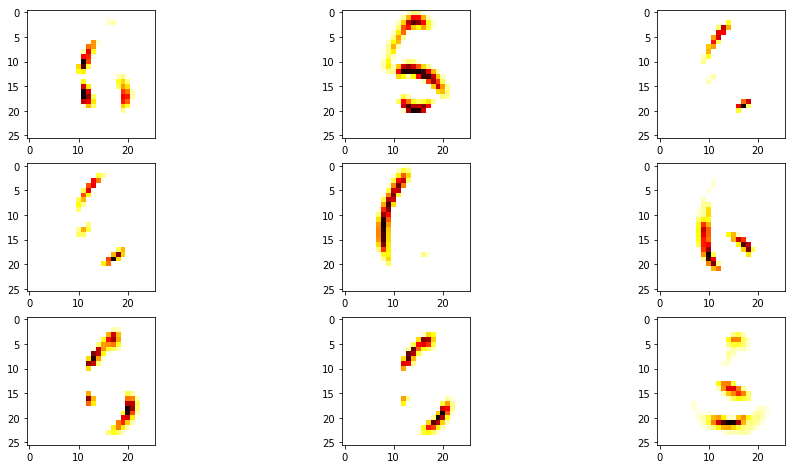

In [275]:
# Visualizando as ativações da imagem através das camadas convoluídas

activated_img = activation[-1]
print("Quantidade de ativações na imagem: ",len(activated_img))

# Para visualizar todos os núcleos usar = int(np.sqrt(layer.filters)) # raiz 64 núcleos, gera plot 8 x 8
# Visualizando apenas 9 núcleos
ativacoes_amostra = 3 
fig = plt.figure(figsize=(16, 8))
vis_images = []
for i in range(ativacoes_amostra):
    for j in range(ativacoes_amostra):
        idx = (ativacoes_amostra*i)+j
        ax = fig.add_subplot(ativacoes_amostra, ativacoes_amostra, idx+1)
        # Algums mapas de cor: Paired, CMRmap_r, Accent, nipy_spectral, gnuplot, gnuplot2, hot_r, jet, ocean_r
        ax.imshow(activated_img[:,:,idx], cmap='hot_r')
        #plt.axis('off')

In [276]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [277]:
# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, 28, 28)) * 20 + 128.

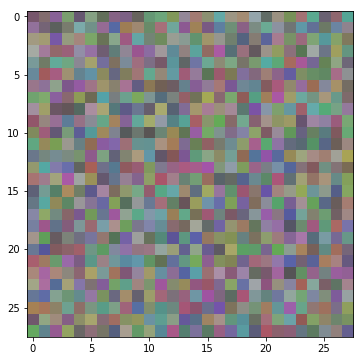

In [278]:

img = input_img_data[0]
img = deprocess_image(img)
# Mostrar a imagem pela média
plt.imshow(img)
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

In [ ]:
# proximo passo é aletar a ativação da camada de relu para softmax, 
# para poder visualizar as caracteristas linearmente separáveis do núcleo